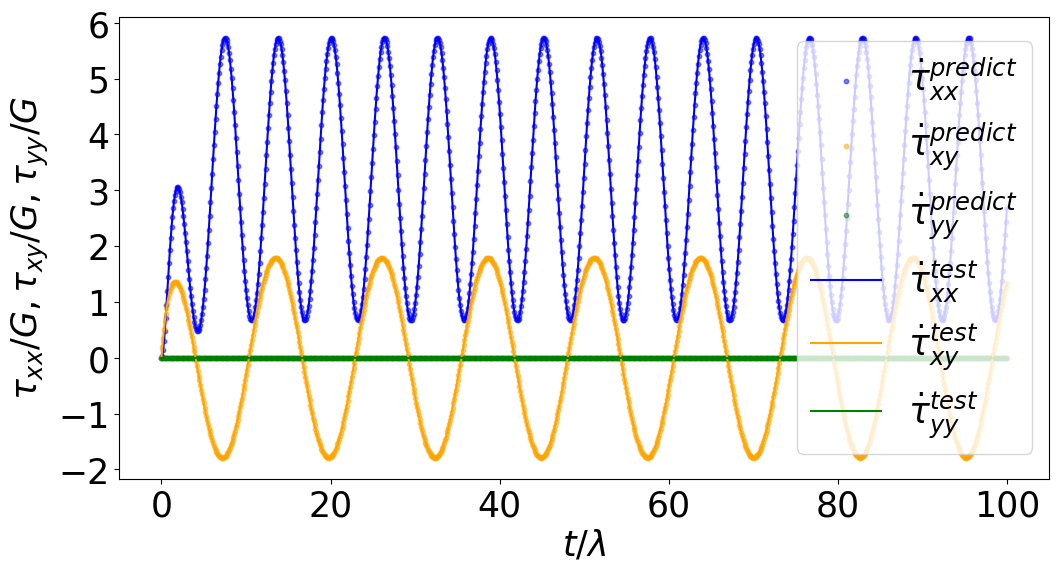

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
import pysindy as ps

def adaptive_lasso(XXX, yyy, alr):
    n_lasso_iterations = 1000
    tol = 1e-4
    kaijo = 5
    abs1 = lambda w: (np.abs(w)**kaijo + 1e-30)

    n_samples, n_features = XXX.shape
    weights = np.ones(n_features)

    for k in range(n_lasso_iterations):
        prevw = np.copy(weights)
        XXX_w = XXX / weights[np.newaxis, :]
        clf = Lasso(alpha=alr, fit_intercept=False, max_iter=n_lasso_iterations, tol=tol)
        clf.fit(XXX_w, yyy)
        coef_ = clf.coef_ / weights
        weights = 1 / abs1(coef_)
        if np.mean((weights - prevw)**2) < tol:
            break

    return coef_

# アッパーコンベクテッド・マクスウェルモデルの右辺
def upper_convected_maxwell_stress(t, y, shear_rate):
    G = 1.0
    λ = 1.0

    # 剪断速度関数
    gamma_dot = shear_rate(t)

    # アッパーコンベクテッド・マクスウェルモデルの微分方程式
    dtau_xx_dt = 2 * G * gamma_dot * y[1]  - (1 / λ) * y[0]
    dtau_xy_dt = G * gamma_dot - (1 / λ) * y[1]
    dtau_yy_dt = - (1 / λ) * y[2]

    return [dtau_xx_dt, dtau_xy_dt, dtau_yy_dt]

# 剪断速度関数
def shear_rate(t, omega=1):
    return 2 * omega * np.cos(omega * t)

def generate_data():
    # 初期条件
    tau0_xx = 0.0
    tau0_xy = 0.0
    tau0_yy = 0.0
    initial_conditions = [tau0_xx, tau0_xy, tau0_yy]

    # 時間の範囲
    t_span = (0, 100)
    t_train = np.linspace(0, 100, 1000)

    # 解く
    x_train = solve_ivp(
        upper_convected_maxwell_stress,
        t_span,
        initial_conditions,
        args=(shear_rate,),
        method='RK45',
        t_eval=t_train
    ).y.T
    #x_train_columns = pd.DataFrame(x_train, columns=['τxx', 'τxy', 'τyy'])
    #x_train = pd.DataFrame(x_train, columns = x_train_columns)
    u_train = shear_rate(t_train)
    u_train = u_train.reshape(-1, 1)
    #u_train_column = pd.DataFrame(u_train, columns=['gamma_dot'])
    #u_train = pd.DataFrame(u_train, columns = u_train_column)
    return t_train, x_train, u_train

def prepare_data_for_sindy(data, control):
    poly = PolynomialFeatures(degree=2)
    general = np.hstack((data, control))
    RHS = poly.fit_transform(general)
    return RHS

def calculate_finite_difference(data, t):
    ddate = ps.FiniteDifference(order=3)._differentiate(data, t)
    return ddate

def adaptive_lasso_regression(RHS, LHS, alpha):
    return adaptive_lasso(RHS, LHS, alr = alpha)

t_train, x_train, u_train = generate_data()

RHS = prepare_data_for_sindy(x_train, u_train)
LHS = calculate_finite_difference(x_train, t_train)

LHS_τxx = LHS[:, 0]
LHS_τxy = LHS[:, 1]
LHS_τyy = LHS[:, 2]

alpha = 1e-6

coef_τxx = adaptive_lasso_regression(RHS, LHS_τxx, alpha)
coef_τxy = adaptive_lasso_regression(RHS, LHS_τxy, alpha)
coef_τyy = adaptive_lasso_regression(RHS, LHS_τyy, alpha)

τxx = coef_τxx.T
τxx = τxx.astype(np.float16)
τxy = coef_τxy.T
τxy = τxy.astype(np.float16)
τyy = coef_τyy.T
τyy = τyy.astype(np.float16)

def upper_convected_maxwell_stress_predict(t, y, shear_rate):
    # 剪断速度関数
    gamma_dot = shear_rate(t)

    # アッパーコンベクテッド・マクスウェルモデルの微分方程式
    dtau_xx_dt = τxx[1] * y[0] + τxx[11] * gamma_dot * y[1] 
    dtau_xy_dt = τxy[2] * y[1] + τxy[4] * gamma_dot 
    dtau_yy_dt = τyy[0] * y[2]
    return [dtau_xx_dt, dtau_xy_dt, dtau_yy_dt]
# 初期条件
tau0_xx = 0.0
tau0_xy = 0.0
tau0_yy = 0.0
initial_conditions = [tau0_xx, tau0_xy, tau0_yy]

def shear_rate_test(t, omega=0.5):
    return 4 * omega * np.cos(omega * t)

# 時間の範囲
t_span = (0, 100)
t_test = np.linspace(0, 100, 1000)

# 解く
x_predict = solve_ivp(
    upper_convected_maxwell_stress_predict,
    t_span,
    initial_conditions,
    args=(shear_rate_test,),
    method='RK45',
    t_eval=t_test
).y.T

x_test = solve_ivp(
    upper_convected_maxwell_stress,
	t_span,
	initial_conditions,
	args=(shear_rate_test,),
	method='RK45',
	t_eval=t_test
).y.T

# 結果のプロット
plt.figure(figsize=(12, 6))

plt.scatter(t_test, x_predict[:, 0], label=r'$\dot{\tau}_{xx}^{predict}$', color='blue', marker='o', s=10, alpha=0.5)
plt.scatter(t_test, x_predict[:, 1], label=r'$\dot{\tau}_{xy}^{predict}$', color='orange', marker='o', s=10, alpha=0.5)
plt.scatter(t_test, x_predict[:, 2], label=r'$\dot{\tau}_{yy}^{predict}$', color='green', marker='o', s=10, alpha=0.5)


# Plot x_test as lines
plt.plot(t_test, x_test[:,0], label=r'$\dot{\tau}_{xx}^{test}$', color='blue')
plt.plot(t_test, x_test[:,1], label=r'$\dot{\tau}_{xy}^{test}$', color='orange')
plt.plot(t_test, x_test[:,2], label=r'$\dot{\tau}_{yy}^{test}$', color='green')

plt.xlabel('$\mathit{t}/\lambda$', fontsize=25)
plt.ylabel('$τ_{xx}/G,τ_{xy}/G,τ_{yy}/G$', fontsize=25, labelpad=5)  # 30はラベルとプロットの間のスペースを調整するための値
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)  # Display legend if labels are provided

plt.show()